In [1]:
import os
import pandas as pd


def construct_squad_dataset():
    filenames = []
    for root, dirs, files in os.walk("users", topdown=True):
            for name in files:
                filenames.append(os.path.join(root, name))


    filenames = [f for f in filenames if 'DS_Store' not in f]
    df = pd.DataFrame({'filename': filenames})

    df['game_type'] = df['filename'].str.split('/').apply(lambda x: x[1])

    df.reset_index(drop=True, inplace=True)

    fn = 'squad_dataset.csv'
    df.to_csv(fn)
    return fn

In [2]:
#df['type'].value_counts()

In [3]:
from torch.utils.data import Dataset
import cv2 as cv

# Make Dataset class
#label_map = {'pass': 0, 'run': 1, 'fake': 2}
label_map = {'notsquads': 0, 'squads': 1}

class GameTypeDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        '''
        '''
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        self.transform = transform
        self.size = (300,100)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = self.dataframe.iloc[idx, 0]
        
        image = cv.imread(img_name)
        #image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        image = cv.resize(image, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return (image, label_map[label])

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader

In [5]:
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)),
                           ])


filename = construct_squad_dataset()

dset = GameTypeDataset(filename, trans)

In [6]:
x, y = dset[0]
x.shape

torch.Size([3, 100, 300])

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(dset, batch_size=15)

In [8]:
'''#batch, labels = next(iter(train_loader))



conv1 = nn.Conv2d(3, 16, kernel_size=5)
x = F.relu(F.max_pool2d(conv1(batch), 2))
print(x.shape)
# torch.Size([15, 16, 48, 148])

conv2 = nn.Conv2d(16, 32, kernel_size=5)
x = F.relu(F.max_pool2d(conv2(x), 2))
print(x.shape)
# torch.Size([15, 32, 22, 72])

conv3 = nn.Conv2d(32, 64, kernel_size=5)
x = F.relu(F.max_pool2d(conv3(x), 2))
print(x.shape)
# torch.Size([15, 64, 9, 34])

x = x.view(15, -1)
# torch.Size([15, 19584])

fc1 = nn.Linear(19584, 100)
x = F.relu(fc1(x))
# torch.Size([15, 100])

x.view(15, -1).shape'''

'#batch, labels = next(iter(train_loader))\n\n\n\nconv1 = nn.Conv2d(3, 16, kernel_size=5)\nx = F.relu(F.max_pool2d(conv1(batch), 2))\nprint(x.shape)\n# torch.Size([15, 16, 48, 148])\n\nconv2 = nn.Conv2d(16, 32, kernel_size=5)\nx = F.relu(F.max_pool2d(conv2(x), 2))\nprint(x.shape)\n# torch.Size([15, 32, 22, 72])\n\nconv3 = nn.Conv2d(32, 64, kernel_size=5)\nx = F.relu(F.max_pool2d(conv3(x), 2))\nprint(x.shape)\n# torch.Size([15, 64, 9, 34])\n\nx = x.view(15, -1)\n# torch.Size([15, 19584])\n\nfc1 = nn.Linear(19584, 100)\nx = F.relu(fc1(x))\n# torch.Size([15, 100])\n\nx.view(15, -1).shape'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(19584, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 19584)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def name(self):
        return "gametype_net_may20"

In [10]:
# HPs
lr = 0.01 # 0.001 too small

# Model
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
num_epochs = 10

for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/10], Loss: 0.8982, Acc: 0.61
Epoch [2/10], Loss: 0.6586, Acc: 0.61
Epoch [3/10], Loss: 0.5359, Acc: 0.61
Epoch [4/10], Loss: 0.37, Acc: 0.93
Epoch [5/10], Loss: 0.2265, Acc: 0.95
Epoch [6/10], Loss: 0.2672, Acc: 0.97
Epoch [7/10], Loss: 0.2759, Acc: 0.97
Epoch [8/10], Loss: 0.1227, Acc: 0.97
Epoch [9/10], Loss: 0.155, Acc: 0.97
Epoch [10/10], Loss: 0.3633, Acc: 0.97


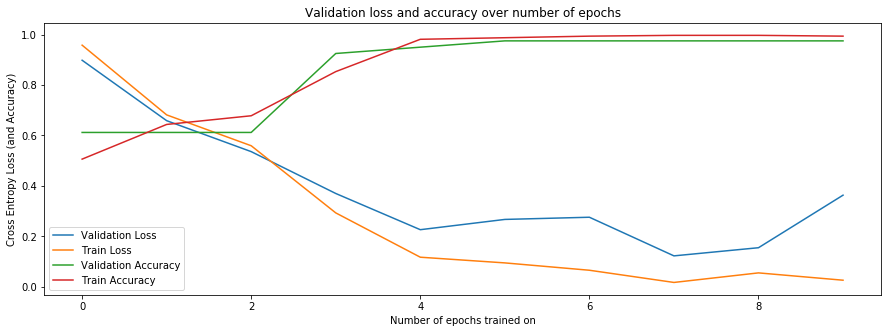

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='lower left');

In [12]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 0.2485, Acc: 0.98


In [13]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)

cm

array([[29,  2],
       [ 0, 49]])

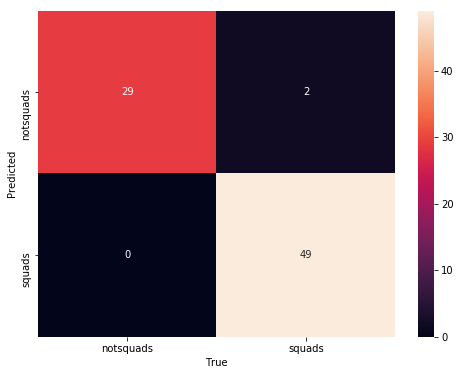

In [14]:
import seaborn as sns

plt.subplots(figsize=(8,6));
sns.heatmap(cm, annot=True, fmt='g', yticklabels=label_map.keys(),
            xticklabels=label_map.keys());

plt.xlabel('True');
plt.ylabel('Predicted');

In [15]:
from sklearn.metrics import classification_report

target_names = label_map.keys()
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   notsquads       1.00      0.94      0.97        31
      squads       0.96      1.00      0.98        49

   micro avg       0.97      0.97      0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



In [16]:
dset.dataframe['game_type'].value_counts()

squads       266
notsquads    134
Name: game_type, dtype: int64

In [17]:
torch.save(model.state_dict(), model.name() + '.pt')